In [2]:
import os
%run {os.environ['jupy']}/default.ipynb

In [3]:
import numpy as np
import os
import pandas as pd
import sys
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from itertools import count
from matplotlib import pyplot as plt, ticker

from kids_ggl_pipeline.halomodel import nfw

# my code
from plottools import plotutils
plotutils.update_rcParams()

#### This is the bias in SUBFIND subhalo mass as a function of distance to host

In [35]:
sfbias = lambda x, a=-1.448, b=1.189, c=0.386: a + b*x**c

In [4]:
sim = 'RefL0100N1504'
snapshot = 26

plot_path = os.path.join('..', 'plots', sim, 'snapshot{0}'.format(snapshot))
if not os.path.isdir(plot_path):
    os.makedirs(plot_path)

In [5]:
path = os.path.join('..', '..', 'data', sim, 'snapshot{0}'.format(snapshot))
group = ascii.read(os.path.join(path, 'groups.txt'))
cent = ascii.read(os.path.join(path, 'centrals.txt'))
sat = ascii.read(os.path.join(path, 'satellites.txt'))
history = ascii.read(os.path.join(path, 'history.txt'))
group = pd.DataFrame(data=group.columns, columns=group.colnames)
cent = pd.DataFrame(data=cent.columns, columns=cent.colnames)
sat = pd.DataFrame(data=sat.columns, columns=sat.colnames)
history = pd.DataFrame(data=history.columns, columns=history.colnames)
print(group['x'].size, 'Groups:', group.columns)
print(cent['x'].size, 'Centrals:', cent.columns)
print(sat['x'].size, 'Satellites:', sat.columns)
display(group[:10])

12144 Groups: Index(['GroupID', 'x', 'y', 'z', 'M', 'M200c', 'M500c', 'M200m', 'R200c',
       'R500c', 'R200m', 'Nsub'],
      dtype='object')
7755 Centrals: Index(['GalaxyID', 'GroupID', 'xm', 'ym', 'zm', 'x', 'y', 'z', 'rhalf_DM',
       'rhalf_gas', 'rhalf_star', 'rphalf_DM', 'rphalf_gas', 'rphalf_star',
       'M', 'M_DM', 'Mstar', 'sfr', 'vx', 'vy', 'vz', 'vmax', 'r_vmax'],
      dtype='object')
5810 Satellites: Index(['GalaxyID', 'GroupID', 'xm', 'ym', 'zm', 'x', 'y', 'z', 'rhalf_DM',
       'rhalf_gas', 'rhalf_star', 'rphalf_DM', 'rphalf_gas', 'rphalf_star',
       'M', 'M_DM', 'Mstar', 'sfr', 'vx', 'vy', 'vz', 'vmax', 'r_vmax'],
      dtype='object')


,GroupID,x,y,z,M,M200c,M500c,M200m,R200c,R500c,R200m,Nsub
0,26000000000000,5.972742,75.567480,47.195652,4.652437e+14,3.318170e+14,2.562827e+14,3.974664e+14,1372.81340,928.07294,1942.3695,13778
1,26000000000001,18.708490,79.925210,54.138893,3.307497e+14,1.640183e+14,1.121906e+14,2.302421e+14,1085.45480,704.68950,1619.1412,9913
2,26000000000002,9.299732,35.015594,54.273197,3.145896e+14,2.626136e+14,1.943604e+14,3.246303e+14,1269.85800,846.32230,1815.5967,9315
3,26000000000003,52.289433,5.008444,20.171661,2.870586e+14,2.609669e+14,2.032776e+14,3.166482e+14,1267.19630,859.08563,1800.6168,7672
4,26000000000004,10.763284,81.740005,55.315815,2.356129e+14,1.877413e+14,1.289096e+14,2.526609e+14,1135.46950,738.09283,1670.0746,6888
5,26000000000005,77.636696,76.473850,41.852844,2.076781e+14,1.006561e+14,7.566555e+13,1.165533e+14,922.43100,617.97350,1290.4421,6903
6,26000000000006,75.868004,89.177760,41.862904,2.033329e+14,1.372079e+14,9.303660e+13,1.668726e+14,1022.81000,662.03690,1454.4614,5697
7,26000000000007,61.776466,33.598824,19.790958,1.214419e+14,4.835496e+13,3.006390e+13,7.664262e+13,722.44135,454.31085,1122.1727,4267
8,26000000000008,84.777565,47.120064,8.229006,1.121182e+14,9.996877e+13,7.716244e+13,1.274512e+14,920.30810,622.02910,1329.5000,3167
9,26000000000009,88.179230,50.473312,4.353087,1.059367e+14,8.665644e+13,5.986910e+13,1.143981e+14,877.52020,571.58670,1282.4464,3473


## Plot mass functions as-they-are

In [6]:
fig, ax = plt.subplots(figsize=(8,7))
bins = np.logspace(8.5, 15, 42)
# groups
#ax = axes[0]
ax.hist(group['M200c'], bins, histtype='step', lw=3, color='k', bottom=1,
        label='FoF groups')
ax.set_xlabel('$M_{200c}$ (M$_\odot$)')
# galaxies
#ax = axes[1]
for sample, name in zip((cent, sat), ('Centrals', 'Satellites')):
    ax.hist(sample['M'], bins, histtype='step', bottom=1,
            lw=3, label=name)
ax.set_xlabel('$M$ (M$_\odot$)')
#for ax in axes:
# dummy
for i in (1,):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1, 5e3)
    ax.legend(loc='best')
    ax.set_ylabel('$1+N(M)$')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10,numticks=7))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=7))

plotutils.savefig(os.path.join(plot_path, 'massfunction.pdf'), fig=fig);

Saved  to ../plots/RefL0100N1504/snapshot26/massfunction.pdf


## Match satellites (and centrals) to their respective group

In [7]:
def dist_to_host(gal, gr, suffixes=('_sat','_host')):
    merged = pd.merge(gal, gr, on='GroupID', suffixes=suffixes, how='left')
    merged['dist_host'] = np.sum(
        (sat[['x','y','z']].values - merged[['x_host','y_host','z_host']].values)**2,
        axis=1)**0.5
    merged['dist_host_norm'] = merged['dist_host'] / (merged['R200m']/1e3)
    for xy in [['x','y'], ['x','z'], ['y','z']]:
        merged['{0}dist_host'.format(''.join(xy))] = np.sum(
            (gal[xy].values \
                - merged[['{0}_host'.format(xy[0]),'{0}_host'.format(xy[1])]].values)**2,
            axis=1)**0.5
        merged['{0}dist_host_norm'.format(''.join(xy))] = \
            merged['{0}dist_host'.format(''.join(xy))] / (merged['R200m']/1e3)
    return merged


def find_nearest(gal, gr, merged=None, xy=''):
    """
    `xy=''` is equivalent to `xy='xyz'` (i.e., 3d distances)
    but will result in nicer labels (just "dist" instead of "xyzdist")
    """
    if not isinstance(xy, str):
        xy = ''.join(xy)
    if not xy:
        dist2 = np.sum((gal[['x','y','z']].values[:,np.newaxis] - gr[['x','y','z']].values)**2, axis=2)
    else:
        dist2 = np.sum((gal[list(xy)].values[:,np.newaxis] - gr[list(xy)].values)**2, axis=2)
    nearest = np.argmin(dist2, axis=1)
    if merged is None:
        merged = gal
    merged['{0}Nearest_idx'.format(xy)] = np.arange(gr.GroupID.size, dtype=int)[nearest]
    merged['{0}Nearest_ID'.format(xy)] = np.array(gr.GroupID, dtype=np.int64)[nearest]
    merged['{0}Nearest_dist'.format(xy)] = np.min(dist2, axis=1)**0.5
    merged['{0}Nearest_dist_norm'.format(xy)] = \
        merged['{0}Nearest_dist'.format(xy)] / np.array(gr.R200m/1e3)[nearest]
    return merged


In [8]:
satgr = dist_to_host(sat, group)

centgr = pd.merge(cent, group, on='GroupID', suffixes=('_cent', '_host'), how='left')
display(centgr[:10])
cent_massive = (centgr['M200m'] > 2e13)
print('{0} centrals of massive groups'.format(cent_massive.sum()))

cent_nearest = find_nearest(cent, group)
print('cent_nearest:')
display(cent_nearest[:10])

# 3d and 2d distances to nearest group
for xy in [[''], ['x','y'], ['x','z'], ['y','z']]:
    satgr = find_nearest(sat, group, satgr, xy)
    print('{0}/{1} galaxies are closer to a group that is not their host'.format(
            (satgr['{0}Nearest_dist'.format(''.join(xy))] < satgr['{0}dist_host'.format(''.join(xy))]).sum(),
            satgr['GalaxyID'].size))
    
print(np.sort(satgr.columns))
display(satgr[:10])

,GalaxyID,GroupID,xm,ym,zm,x_cent,y_cent,z_cent,rhalf_DM,rhalf_gas,...,y_host,z_host,M_host,M200c,M500c,M200m,R200c,R500c,R200m,Nsub
0,47681,26000000004706,7.926265,82.412620,56.205410,7.926164,82.412050,56.206936,30.990000,11.367657,...,82.412050,56.206936,2.820693e+11,2.011227e+11,1.663520e+11,2.671280e+11,116.179620,80.357346,170.14174,7.0
1,48094,26000000003441,20.711971,79.134995,53.254486,20.706180,79.136020,53.249050,53.012180,70.987610,...,79.136020,53.249050,4.245247e+11,2.620848e+11,1.930298e+11,3.231484e+11,126.899500,84.437190,181.28412,16.0
2,53605,26000000006034,15.637856,80.353730,53.106300,15.637446,80.352510,53.107452,30.617273,19.934559,...,80.352510,53.107452,1.842991e+11,1.482012e+11,1.294872e+11,1.745879e+11,104.936200,73.916820,147.64793,5.0
3,55735,26000000004522,17.775414,78.390045,54.464943,17.779785,78.387560,54.465120,40.050674,4.818975,...,78.387550,54.465120,2.392073e+11,1.606821e+11,1.179187e+11,2.460558e+11,107.801320,71.645570,165.54315,19.0
4,62450,26000100001103,14.985726,80.179850,50.979790,14.986866,80.178030,50.977577,40.339268,6.441914,...,80.178030,50.977577,1.442603e+11,1.331343e+11,1.049184e+11,1.592913e+11,101.252780,68.913070,143.20860,8.0
5,63432,26000000004760,20.038681,78.641470,52.615970,20.037958,78.641410,52.616833,40.430798,3.939164,...,78.641410,52.616833,3.098230e+11,2.288184e+11,1.853363e+11,2.752854e+11,121.284650,83.302810,171.84984,17.0
6,64988,26000100000087,12.937562,81.420760,54.255272,12.936369,81.421820,54.253094,24.806034,0.000000,...,81.421820,54.253094,1.601964e+11,1.184053e+11,9.892053e+10,1.676014e+11,97.372780,67.574326,145.65817,7.0
7,66591,26000100002864,8.464085,81.250960,56.244625,8.463855,81.250680,56.244260,19.657255,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,69314,26000100002221,13.853775,81.223130,56.858482,13.854639,81.220024,56.857870,24.565355,2.364759,...,81.220024,56.857864,1.127216e+11,9.499678e+10,7.966647e+10,1.275059e+11,90.477425,62.869965,132.96739,5.0
9,69845,26000100000133,9.154927,82.793910,57.595615,9.152954,82.795490,57.595780,37.744686,2.879714,...,82.795490,57.595780,1.589279e+11,1.451453e+11,1.201260e+11,1.737010e+11,104.211880,72.092810,147.40262,4.0


88 centrals of massive groups
cent_nearest:


,GalaxyID,GroupID,xm,ym,zm,x,y,z,rhalf_DM,rhalf_gas,...,sfr,vx,vy,vz,vmax,r_vmax,Nearest_idx,Nearest_ID,Nearest_dist,Nearest_dist_norm
0,47681,26000000004706,7.926265,82.412620,56.205410,7.926164,82.412050,56.206936,30.990000,11.367657,...,0.308155,734.790900,-648.092600,-530.76010,123.767654,14.397245,4705,26000000004706,0.000000e+00,0.000000
1,48094,26000000003441,20.711971,79.134995,53.254486,20.706180,79.136020,53.249050,53.012180,70.987610,...,0.224028,-1018.906000,196.054920,109.77600,115.052765,11.759777,3441,26000000003441,0.000000e+00,0.000000
2,53605,26000000006034,15.637856,80.353730,53.106300,15.637446,80.352510,53.107452,30.617273,19.934559,...,0.443948,-403.532230,-420.028320,203.41757,109.733340,12.586855,6031,26000000006034,1.000000e-06,0.000007
3,55735,26000000004522,17.775414,78.390045,54.464943,17.779785,78.387560,54.465120,40.050674,4.818975,...,0.453195,-917.044430,475.687870,345.46255,91.839480,15.178546,4521,26000000004522,1.000000e-05,0.000060
4,62450,26000100001103,14.985726,80.179850,50.979790,14.986866,80.178030,50.977577,40.339268,6.441914,...,0.154714,-190.360600,-306.990420,384.26960,88.161606,20.075340,8804,26000100001103,0.000000e+00,0.000000
5,63432,26000000004760,20.038681,78.641470,52.615970,20.037958,78.641410,52.616833,40.430798,3.939164,...,0.281347,-1014.587600,321.840450,-131.33235,110.369190,15.115102,4759,26000000004760,2.000000e-06,0.000012
6,64988,26000100000087,12.937562,81.420760,54.255272,12.936369,81.421820,54.253094,24.806034,0.000000,...,0.000000,16.317135,-88.891365,-409.05872,99.410800,16.708523,7823,26000100000087,1.000000e-06,0.000007
7,66591,26000100002864,8.464085,81.250960,56.244625,8.463855,81.250680,56.244260,19.657255,0.000000,...,0.000000,281.258200,56.155125,-450.94992,96.644540,12.274827,4705,26000000004706,1.280346e+00,7.525171
8,69314,26000100002221,13.853775,81.223130,56.858482,13.854639,81.220024,56.857870,24.565355,2.364759,...,0.120531,-247.421720,-374.861000,-1029.93440,93.707310,15.245285,9849,26000100002221,6.000000e-06,0.000045
9,69845,26000100000133,9.154927,82.793910,57.595615,9.152954,82.795490,57.595780,37.744686,2.879714,...,0.251360,822.730800,-686.770400,-765.86670,100.583420,10.958036,7866,26000100000133,0.000000e+00,0.000000


893/5810 galaxies are closer to a group that is not their host
2662/5810 galaxies are closer to a group that is not their host
2784/5810 galaxies are closer to a group that is not their host
2737/5810 galaxies are closer to a group that is not their host
['GalaxyID' 'GroupID' 'M200c' 'M200m' 'M500c' 'M_DM' 'M_host' 'M_sat'
 'Mstar' 'Nearest_ID' 'Nearest_dist' 'Nearest_dist_norm' 'Nearest_idx'
 'Nsub' 'R200c' 'R200m' 'R500c' 'dist_host' 'dist_host_norm' 'r_vmax'
 'rhalf_DM' 'rhalf_gas' 'rhalf_star' 'rphalf_DM' 'rphalf_gas' 'rphalf_star'
 'sfr' 'vmax' 'vx' 'vy' 'vz' 'x_host' 'x_sat' 'xm' 'xyNearest_ID'
 'xyNearest_dist' 'xyNearest_dist_norm' 'xyNearest_idx' 'xydist_host'
 'xydist_host_norm' 'xzNearest_ID' 'xzNearest_dist' 'xzNearest_dist_norm'
 'xzNearest_idx' 'xzdist_host' 'xzdist_host_norm' 'y_host' 'y_sat' 'ym'
 'yzNearest_ID' 'yzNearest_dist' 'yzNearest_dist_norm' 'yzNearest_idx'
 'yzdist_host' 'yzdist_host_norm' 'z_host' 'z_sat' 'zm']


,GalaxyID,GroupID,xm,ym,zm,x_sat,y_sat,z_sat,rhalf_DM,rhalf_gas,...,xyNearest_dist,xyNearest_dist_norm,xzNearest_idx,xzNearest_ID,xzNearest_dist,xzNearest_dist_norm,yzNearest_idx,yzNearest_ID,yzNearest_dist,yzNearest_dist_norm
0,3,26000000000004,10.676504,81.724070,55.323150,10.676117,81.723870,55.323174,8.904130,0.000000,...,0.088648,0.053080,4,26000000000004,0.087477,0.052379,4,26000000000004,0.017734,0.010619
1,13633,26000000000001,18.766990,79.880360,54.251564,18.766426,79.879480,54.251694,11.086453,0.000000,...,0.073809,0.045585,1,26000000000001,0.126809,0.078319,1,26000000000001,0.121718,0.075174
2,21795,26000000000004,10.640868,81.904700,55.391033,10.640938,81.904915,55.391296,8.631454,0.000000,...,0.205338,0.122952,4,26000000000004,0.143756,0.086078,10773,26000100003252,0.078064,0.592452
3,23303,26000000000004,10.720372,82.034325,55.440050,10.720102,82.035590,55.440372,13.246635,0.000000,...,0.298723,0.178868,4,26000000000004,0.131830,0.078937,10773,26000100003252,0.104941,0.796431
4,24474,26000000000004,10.720508,82.035150,55.439865,10.720475,82.035126,55.439842,0.000000,0.000000,...,0.298210,0.178561,4,26000000000004,0.131207,0.078564,10773,26000100003252,0.104240,0.791108
5,24479,26000000000001,17.905313,80.044450,53.676780,17.904818,80.044100,53.676167,16.616331,0.000000,...,0.446977,1.798582,4521,26000000004522,0.798799,4.825323,7190,26000000007201,0.187755,1.236537
6,26265,26000000000001,18.668016,79.865140,54.033566,18.667889,79.865000,54.033524,5.794720,0.000000,...,0.072620,0.044851,1,26000000000001,0.112921,0.069741,9016,26000100001331,0.032494,0.262573
7,27475,26000000000004,10.636128,81.933426,55.166782,10.636000,81.933440,55.166645,9.988746,0.000000,...,0.231556,0.138650,4,26000000000004,0.196094,0.117416,9765,26000100002129,0.059539,0.440050
8,28852,26000000000001,18.529860,80.159240,54.326656,18.529095,80.159780,54.326714,10.728441,0.000000,...,0.261690,2.016775,1,26000000000001,0.259729,0.160412,997,26000000000547,0.130675,0.321364
9,29819,26000000000004,12.315205,80.951805,55.128260,12.315942,80.956650,55.132570,25.242516,1.304345,...,0.468781,2.593679,8757,26000100001054,0.528399,3.686429,6303,26000000006306,0.288117,1.775073


Projection effects result in some cases in the host group not being the nearest group.

*It's not always projection effects.

#### As an example, the most massive cluster:

,GalaxyID,GroupID,xm,ym,zm,x_sat,y_sat,z_sat,rhalf_DM,rhalf_gas,...,xyNearest_dist,xyNearest_dist_norm,xzNearest_idx,xzNearest_ID,xzNearest_dist,xzNearest_dist_norm,yzNearest_idx,yzNearest_ID,yzNearest_dist,yzNearest_dist_norm
1,13633,26000000000001,18.766990,79.880360,54.251564,18.766426,79.879480,54.251694,11.086453,0.000000,...,0.073809,0.045585,1,26000000000001,0.126809,0.078319,1,26000000000001,0.121718,0.075174
5,24479,26000000000001,17.905313,80.044450,53.676780,17.904818,80.044100,53.676167,16.616331,0.000000,...,0.446977,1.798582,4521,26000000004522,0.798799,4.825323,7190,26000000007201,0.187755,1.236537
6,26265,26000000000001,18.668016,79.865140,54.033566,18.667889,79.865000,54.033524,5.794720,0.000000,...,0.072620,0.044851,1,26000000000001,0.112921,0.069741,9016,26000100001331,0.032494,0.262573
8,28852,26000000000001,18.529860,80.159240,54.326656,18.529095,80.159780,54.326714,10.728441,0.000000,...,0.261690,2.016775,1,26000000000001,0.259729,0.160412,997,26000000000547,0.130675,0.321364
10,30904,26000000000001,19.267372,79.736115,52.965157,19.265656,79.736374,52.965670,22.768785,0.000000,...,0.082979,0.598031,11277,26000100003853,0.170259,1.376162,8172,26000100000447,0.233684,1.620791
11,32368,26000000000001,19.243954,80.203070,52.711636,19.242620,80.202380,52.712185,23.673235,1.363582,...,0.394743,2.844908,11277,26000100003853,0.401189,3.242708,11906,26000100004761,0.278948,2.221887
12,33117,26000000000001,18.568920,80.856680,53.063164,18.568417,80.857570,53.063190,19.184624,3.636787,...,0.408857,2.034403,8750,26000100001047,0.702877,4.875177,2944,26000000002944,0.387535,1.782958
14,34158,26000000000001,18.792221,80.151665,53.991226,18.792078,80.151760,53.991146,7.140998,0.000000,...,0.241478,0.149140,1,26000000000001,0.169753,0.104841,7298,26000000007309,0.057585,0.388354
15,35659,26000000000001,17.671537,79.658640,53.000507,17.671133,79.658290,53.000504,13.149221,0.000000,...,0.340966,1.372008,6024,26000000006027,1.022192,7.621189,8172,26000100000447,0.317569,2.202596
16,36470,26000000000001,17.013485,78.562410,53.310310,17.013592,78.563190,53.310898,21.430124,0.000000,...,0.527261,2.834147,10789,26000100003270,0.578826,4.680178,2382,26000000002421,0.035464,0.194062


Group 26000000000001 contains 152 massive satellites
Its central subhalo is # 21109762.
134 satellites are closer to some other group in xy projection, belonging to 134 different groups,
the least massive of which is 1 with M=2.30e+14 Msun/h
[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.72300000e+03   3.09700000e+03
   3.58100000e+03   4.14800000e+03   4.14800000e+03   4.14800000e+03
   4.14800000e+03   4.14800000e+03   4.14800000e+03   4.14800000e+03
   4.14800000e+03   4.14800000e+03   4.52100000e+03   4.52100000e+03

/Users/cristobal/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/cristobal/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


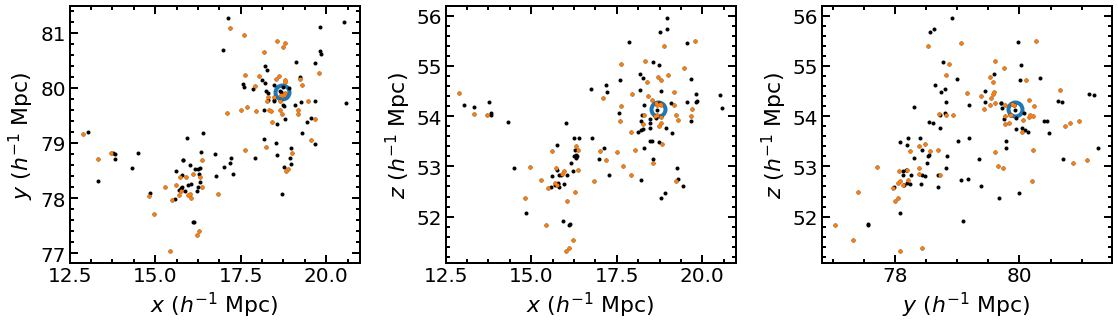

In [9]:
fig, axes = plt.subplots(figsize=(16,5), ncols=3)
example = 26000000000001
jgr = (group['GroupID'] == example)
j = (satgr['GroupID'] == example)
display(satgr[j][:10])
print('Group {0} contains {1} massive satellites'.format(example, j.sum()))
members = satgr[j]
example_cent = cent['GalaxyID'][cent['GroupID'] == example].values[0]
print('Its central subhalo is # {0}.'.format(example_cent))

projections = ('xy', 'xz', 'yz')
for ax, proj in zip(axes, projections):
    ax.plot(group[proj[0]][jgr], group[proj[1]][jgr], 'C0o', mfc='none', mew=4, ms=14)
    #nearcol = '{0}Nearest_ID'.format(proj)
    nearcol = '{0}Nearest_dist'.format(proj)
    hostcol = '{0}dist_host'.format(proj)
    ax.plot(sat[proj[0]][j], sat[proj[1]][j], 'k.')
    # satellites which are closer in projection to some other group
    ambiguous = np.array([i for i, nearest, host
                          in zip(count(), satgr[nearcol][j], satgr[hostcol][j])
                          if (not np.isnan(host) and nearest < host)])
    print('{0} satellites are closer to some other group in {1} projection,'
          ' belonging to {2} different groups,'.format(
                ambiguous.size, proj, np.unique(satgr[nearcol][j][ambiguous]).size))
    print('the least massive of which is {0} with M={1:.2e} Msun/h'.format(
            np.argmin(satgr['M200m'][j][ambiguous]), satgr['M200m'][j][ambiguous].min()))
    print(np.sort(satgr['Nearest_idx'][j][ambiguous]))
    #print(np.unique(satgr['x_host'][j][ambiguous]))
    ax.plot(sat[proj[0]][j][ambiguous], sat[proj[1]][j][ambiguous], 'C1.')
    # other FoF groups in the vicinity
    close = (np.sum(group))
    ax.set_xlabel('${0}$ ($h^{{-1}}$ Mpc)'.format(proj[0]))
    ax.set_ylabel('${0}$ ($h^{{-1}}$ Mpc)'.format(proj[1]))

fig.tight_layout();

In addition, some satellites are hosted by groups less massive than the cut I applied to the downloaded catalog
(namely, $M_{200m}>10^{11}\,h^{-1}\mathrm{M}_\odot$):

In [10]:
inmassive = np.isfinite(satgr['{0}{1}dist_host'.format(*xy)])
print('{0}/{1} satellites in massive groups'.format(inmassive.sum(), inmassive.size))
print('GroupID:', sat['GroupID'][~inmassive].values[0])
print('(x,y)_group:', satgr['x_host'][~inmassive].values[0],
      satgr['y_host'][~inmassive].values[0])
print('Entry in Group table:')
display(group[group['GroupID'] == 26000000003580])

5809/5810 satellites in massive groups
GroupID: 26000000003580
(x,y)_group: nan nan
Entry in Group table:


,GroupID,x,y,z,M,M200c,M500c,M200m,R200c,R500c,R200m,Nsub


These will be counted as not having been in a cluster previously

### Now match all galaxies to their nearest *cluster*

In [11]:
Mcl_min = 2e13
cl = (group['M200m'] > Mcl_min)
print('There are {0} clusters with M > {1:.1e} Msun/h'.format(
        cl.sum(), Mcl_min))

cluster = group[cl]

gal = pd.concat([cent, sat])
galcl = find_nearest(gal, cluster)
for xy in ('xy','xz','yz'):
    galcl = find_nearest(gal, cluster, galcl, xy)
display(galcl[:10])

# removing the clusters' central galaxies:
cl_centrals = (galcl['Nearest_dist'] < 1e-4)
satcl = galcl[~cl_centrals]

There are 88 clusters with M > 2.0e+13 Msun/h


,GalaxyID,GroupID,M,M_DM,Mstar,Nearest_ID,Nearest_dist,Nearest_dist_norm,Nearest_idx,r_vmax,...,xyNearest_dist,xyNearest_dist_norm,xzNearest_idx,xzNearest_ID,xzNearest_dist,xzNearest_dist_norm,yzNearest_idx,yzNearest_ID,yzNearest_dist,yzNearest_dist_norm
0,47681,26000000004706,1.877593e+11,1.808514e+11,5.103684e+09,26000000000004,3.048769,1.825528,4,14.397245,...,2.915629,1.745808,2,26000000000002,2.371927,1.306417,4,26000000000004,1.116128,0.668310
1,48094,26000000003441,2.682974e+11,2.605350e+11,3.974296e+09,26000000000001,2.324953,1.435917,1,11.759777,...,2.116725,2.186695,1,26000000000001,2.186912,1.350662,1,26000000000001,1.189387,0.734579
2,53605,26000000006034,1.441719e+11,1.318138e+11,5.588092e+09,26000000000001,3.267685,2.018160,1,12.586855,...,2.600420,3.320681,1,26000000000001,3.239627,2.000830,1,26000000000001,1.116448,0.689531
3,55735,26000000004522,1.406660e+11,1.358276e+11,3.280692e+09,26000000000001,1.825728,1.127591,1,15.178546,...,0.494085,0.630935,1,26000000000001,0.984336,0.607937,1,26000000000001,1.571875,0.970808
4,62450,26000100001103,1.354401e+11,1.332972e+11,1.459735e+09,26000000000017,3.346736,3.040502,17,20.075340,...,2.709377,2.461463,17,26000000000017,2.177468,1.978225,29,26000000000029,2.375430,2.453953
5,63432,26000000004760,2.137507e+11,2.093548e+11,3.506658e+09,26000000000001,2.394221,1.478698,1,15.115102,...,1.848142,1.141433,1,26000000000001,2.020928,1.248148,1,26000000000001,1.991183,1.229777
6,64988,26000100000087,1.063492e+11,1.044156e+11,1.928145e+09,26000000000004,2.439860,1.460929,4,16.708523,...,2.196256,1.315065,4,26000000000004,2.419023,1.448452,4,26000000000004,1.109332,0.664241
7,66591,26000100002864,7.347705e+10,6.643046e+10,7.042988e+09,26000000000004,2.527612,1.513473,4,12.274827,...,2.350917,1.407672,2,26000000000002,2.140976,1.179214,4,26000000000004,1.049499,0.628415
8,69314,26000100002221,8.826914e+10,8.532610e+10,2.609904e+09,26000000000004,3.493535,2.091844,4,15.245285,...,3.134782,1.877031,52,26000000000053,2.818530,3.311348,86,26000000000094,0.759815,1.043113
9,69845,26000100000133,1.474817e+11,1.435933e+11,3.133801e+09,26000000000004,2.984200,1.786866,4,10.958036,...,1.925412,1.152890,4,26000000000004,2.791308,1.671368,86,26000000000094,0.987744,1.356025


Migh need to include indices in these merged tables to more easily cross-match the tables (for instance, when binning by cluster-centric distance and cluster mass)

## Plot the radial distribution of satellites in bins of group mass

1
1
1


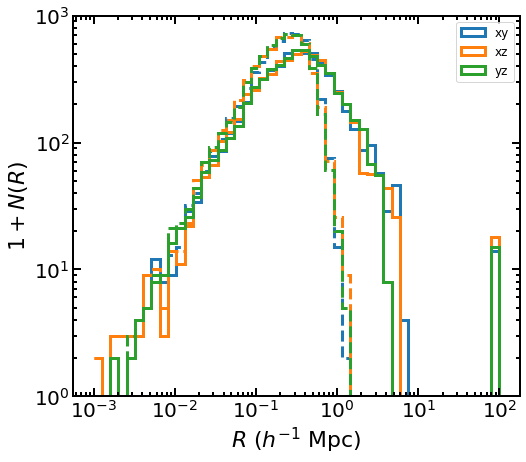

In [12]:
bins = np.logspace(-3, 2, 50)
xo = (bins[:-1]+bins[1:]) / 2
fig, ax = plt.subplots(figsize=(8,7))
for i, proj in enumerate(projections):
    print(np.isnan(satgr['{0}dist_host'.format(proj)]).sum())
    ax.hist(satgr['{0}dist_host'.format(proj)][inmassive], bins, color='C{0}'.format(i),
            histtype='step', lw=3, bottom=1, label=proj)
    ax.hist(satgr['{0}Nearest_dist'.format(proj)], bins, color='C{0}'.format(i),
            histtype='step', lw=3, ls='dashed', bottom=1, label='_none_')
# add NFW
rs = 50
sigma_s = 9e12
ynfw = nfw.sigma(xo/rs, sigma_s)
#ax.plot(xo, ynfw, 'k-', label='$\Sigma_\mathrm{{NFW}}$ ($r_\mathrm{{s}}={}$ $h^{{-1}}$ Mpc)'.format(rs))

ax.set_ylim(1, 1e3)
ax.set_xlabel('$R$ ($h^{-1}$ Mpc)')
ax.set_ylabel('$1+N(R)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=12);

It makes sense that the "Nearest" histograms (dashed) show a distribution towards smaller values than the "Host" histograms (solid).

### First, the total-to-stellar mass relation of central galaxies

In [13]:
mstarbins = np.logspace(9, 12, 9)
mstar = (mstarbins[:-1]+mstarbins[1:]) / 2
ccut = pd.cut(centgr.Mstar, mstarbins)
cbinned = centgr.groupby(ccut)
m200m = cbinned.M200m.mean().values
m200m_lo = cbinned.M200m.quantile(0.16).values
m200m_hi = cbinned.M200m.quantile(0.84).values
cgood = np.isfinite(m200m)
print(cbinned.size().values)
print(m200m)

[2681 1887 1270  958  601  268   72   12]
[  2.24382206e+11   3.54537554e+11   6.62292838e+11   1.31498225e+12
   3.40828998e+12   9.73598940e+12   3.27057453e+13   8.74077062e+13]


### Now of all satellites

In [14]:
scut = pd.cut(satgr.Mstar, mstarbins)
sbinned = satgr.groupby(scut)
msub = sbinned.M_sat.mean().values
msub_lo = sbinned.M_sat.quantile(0.16).values
msub_hi = sbinned.M_sat.quantile(0.84).values
sgood = np.isfinite(msub)
print(sbinned.size().values)
print(msub)

[2208 1528  985  672  319   83   10    5]
[  5.11110684e+10   8.28446649e+10   1.52003410e+11   3.03573371e+11
   7.65816665e+11   2.60675967e+12   9.29667142e+12   4.46455843e+13]


### Now of satellites binned by (3d) distance to host group/cluster

In [15]:
def mean(groupby_obj, colname, shape, axis=0):
    N = groupby_obj.count()[colname].fillna(0).values.reshape(shape)
    avg = groupby_obj.mean()[colname].fillna(0).values.reshape(shape)
    return np.sum(avg*N, axis=axis) / np.sum(N, axis=axis)

In [24]:
Rbins = np.array([0.01, 0.3, 0.5, 1, 2, 5])
R = (Rbins[:-1]+Rbins[1:]) / 2
#print(satgr.columns)

# Note that cluster sizes are given in pkpc
sRbinned = satgr.groupby([scut, pd.cut(satgr.dist_host_norm, Rbins)])
#print(satgr.dist_host/satgr.R200m)
msub_R = sRbinned.mean().M_sat.values.reshape((mstar.size,R.size))
#print(msub_R)
# average normalized cluster-centric distance
Ravg_sat = mean(sRbinned, 'xydist_host_norm', (mstar.size,R.size))
print(Ravg_sat)

[ 0.14099916  0.31593923  0.58181412  1.10643447  2.14748405]


### Now of all galaxies binned by distance to nearest massive cluster

In [25]:
# I'm using the distances in the xy plane
print(galcl.columns)
clbinned = galcl.groupby([pd.cut(galcl.Mstar, mstarbins),
                          pd.cut(galcl.xyNearest_dist, Rbins)])
msub_cl = clbinned.mean().M.values.reshape((mstar.size,R.size))
Ravg_cl = mean(clbinned, 'xyNearest_dist_norm', (mstar.size,R.size))
print(Ravg_cl)

Index(['GalaxyID', 'GroupID', 'M', 'M_DM', 'Mstar', 'Nearest_ID',
       'Nearest_dist', 'Nearest_dist_norm', 'Nearest_idx', 'r_vmax',
       'rhalf_DM', 'rhalf_gas', 'rhalf_star', 'rphalf_DM', 'rphalf_gas',
       'rphalf_star', 'sfr', 'vmax', 'vx', 'vy', 'vz', 'x', 'xm', 'y', 'ym',
       'z', 'zm', 'xyNearest_idx', 'xyNearest_ID', 'xyNearest_dist',
       'xyNearest_dist_norm', 'xzNearest_idx', 'xzNearest_ID',
       'xzNearest_dist', 'xzNearest_dist_norm', 'yzNearest_idx',
       'yzNearest_ID', 'yzNearest_dist', 'yzNearest_dist_norm'],
      dtype='object')
[ 0.16596883  0.37745581  0.72620479  1.54492551  3.64791027]


Their histogram is shown below:

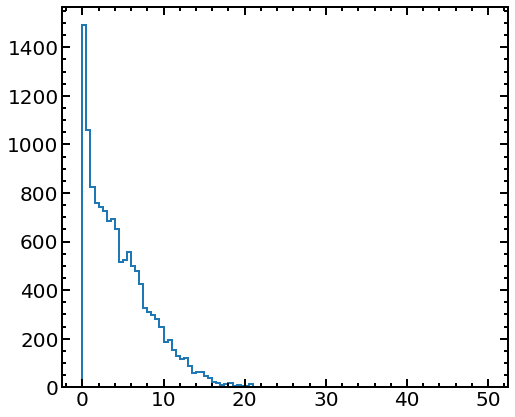

In [26]:
fig, ax = plt.subplots(figsize=(8,7))
bins_Rhist = np.arange(0, 50.01, 0.5)
ax.hist(satcl.xyNearest_dist_norm, bins_Rhist, histtype='step', lw=2);
#ax.set_yscale('log');

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$m_\star\,(h^{-1}\,\mathrm{M}_\odot$)')
#ax.set_ylabel('$M_{200m}\,(h^{-1}\,\mathrm{M}_\odot$)')
ax.set_ylabel(r'$M_\mathrm{tot}\,(h^{-1}\,\mathrm{M}_\odot)$')

# centrals
ax.plot(mstar, m200m, 'k-', lw=2,
        label='Centrals ($M_\mathrm{tot}=M_{200m}$)')
ax.fill_between(mstar[cgood], m200m_lo[cgood], m200m_hi[cgood],
                color='k', alpha=0.3, zorder=-1)
# all satellites
satcolor = '0.6'
ax.plot(mstar, msub, '-', color=satcolor, lw=2,
        label='All satellites ($M_\mathrm{tot}=m_\mathrm{sub}$)')
ax.fill_between(mstar[sgood], msub_lo[sgood], msub_hi[sgood],
                color=satcolor, alpha=0.3, zorder=-1)
# satellites binned by distance to the centre
lines = []
# need 2 colorbars because the arrays of Ravg are different
## might want to make a discrete colorbar so I don't have to worry about
## little differences in average R between the two samples.
colors, colorbar = plotutils.colorscale(
    n=Ravg_sat.size, vmin=0, vmax=Rbins[-1], cmap='plasma')
for i in range(R.size):
    print(i)
    # in all groups
    ax.plot(mstar, msub_R[:,i], '-', color=colors[i], lw=3)#,
            #label='{0} $<$ $R/R_{{200m}}$ $<$ {1}'.format(Rbins[i],Rbins[i+1]))
    print(msub_R[:,i])
    # in massive groups
    #ax.plot(mstar, msub_cl[:,i], dashes=(8,2), color=colors[i], lw=2,
            #label='_none_')
    print(msub_cl[:,i])
    # corrected for the SUBFIND bias -- note that this applies only to subhalos,
    # and I believe the distance here should be 3d
    if R[i] < 1.5:
        ax.plot(mstar, msub_R[:,i]/(1+sfbias(R[i])),
                dashes=(6,4,2,4), color=colors[i], lw=2,
                label='_none_')
        print(msub_R[:,i]/(1+sfbias(R[i])))
    if i == 0:
        lines.append(ax.plot([], [], 'k-')[0])
        #lines.append(ax.plot([], [], 'k', dashes=(8,2), lw=2)[0])
        lines.append(ax.plot([], [], 'k', dashes=(6,4,2,4), lw=2)[0])
#cbar = plt.colorbar(colorbar, ax=ax, orientation='horizontal', pad=0.1)
cbar = plt.colorbar(colorbar, ax=ax)#, orientation='horizontal', pad=0.1)
cbar.set_label('$R/R_{{200m}}$')

leg = ax.legend(loc='upper left', fontsize=12, frameon=False)
ax.annotate('Colors:', xy=(1.8e10,3.5e10), ha='left', va='bottom', fontsize=12)
ax.legend(lines,
          ('Satellites of all groups', #'Galaxies around massive groups',
           'All satellites, corrected'),
          loc='lower right', fontsize=12, frameon=False)
plt.gca().add_artist(leg)
plotutils.savefig(os.path.join(plot_path, 'total_to_stellar_groups_and_clusters.pdf'));

0
[  1.31886760e+10   2.50877700e+10   5.04933300e+10   1.08227837e+11
   2.26502531e+11   5.73299022e+11   1.67820067e+12              nan]
[  3.17462184e+10   4.01768965e+10   7.75720659e+10   1.58121424e+11
   5.32537472e+11   1.52875500e+12   1.72546903e+12              nan]
[  1.00706302e+11   1.91565594e+11   3.85557775e+11   8.26407846e+11
   1.72953164e+12   4.37760581e+12   1.28144314e+13              nan]
1
[  2.73133168e+10   4.84358468e+10   9.38316274e+10   1.93581136e+11
   4.64430109e+11   1.32132800e+12   1.72546903e+12   1.20944538e+13]
[  5.40849254e+10   7.21168765e+10   1.43452959e+11   3.08834994e+11
   7.90842132e+11   2.22115544e+12   7.85327777e+12   1.20944538e+13]
[  7.06154439e+10   1.25225320e+11   2.42590897e+11   5.00481797e+11
   1.20073071e+12   3.41614181e+12   4.46100203e+12   3.12688214e+13]
2
[  5.30737074e+10   8.87768218e+10   1.58915477e+11   3.44218511e+11
   7.53091541e+11   2.18695894e+12   3.56313646e+12              nan]
[  7.45286770e+10   1

The dash-dotted lines (i.e., those corrected for the subfind bias) lie above the observed relation at $R=5R_{200m}$. This is a factor $\sim$10 correction. Perhaps we shouldn't believe any of this?

# Distances in the plot above are 3-dimensional. A quick look at binning by projected distance shows that differences between bins are somewhat reduced (as expected).

I don't think dashed and dotted lines should be terribly correlated because the vast majority of groups are less massive than my "clusters"

### Now plot the opposite projection

Such a plot can be compared to the one in Knebe+11 which shows the bias in recovered mass as a function of halo-centric distance: can the bias in SUBFIND explain the trend?

1685686852.83 [  1.31886760e+10   2.73133168e+10   5.30737074e+10   8.49580117e+10
   8.25451065e+10]
3997393478.78 [  2.50877700e+10   4.84358468e+10   8.87768218e+10   1.34253969e+11
   1.35326451e+11]
9479313786.77 [  5.04933300e+10   9.38316274e+10   1.58915477e+11   2.63726981e+11
   2.43677982e+11]
22478995461.7 [  1.08227837e+11   1.93581136e+11   3.44218511e+11   4.58014582e+11
   6.09893998e+11]
53306098767.5 [  2.26502531e+11   4.64430109e+11   7.53091541e+11   1.34203212e+12
   1.63925407e+12]
126408680969.0 [  5.73299022e+11   1.32132800e+12   2.18695894e+12   3.78719246e+12
   4.70503442e+12]
299762222216.0 [  1.67820067e+12   1.72546903e+12   3.56313646e+12   1.06477329e+13
   1.99229199e+13]
710848251714.0 [             nan   1.20944538e+13              nan   3.79981284e+13
   6.75686055e+13]


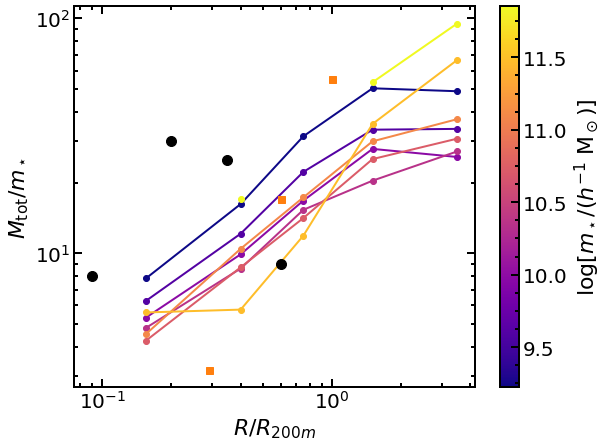

In [21]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$R/R_{200m}$')
ax.set_ylabel('$M_\mathrm{tot}/m_\star$')

colors, colorbar = plotutils.colorscale(
    array=np.log10(mstar), cmap='plasma')

for i in range(mstar.size):
    print(mstar[i], msub_R[i])
    ax.plot(R, msub_R[i]/mstar[i], 'o-', color=colors[i], lw=2)
    
# MENeaCS (by eye)
rmen = np.array([0.09, 0.2, 0.35, 0.6])
ymen = np.array([8, 30, 25, 9])
ax.plot(rmen, ymen, 'ko', ms=10, label='Meneacs')
# Li+16
rli = np.array([0.29, 0.6, 1.])
yli = np.array([3.2, 17, 55])
ax.plot(rli, yli, 'C1s', ms=7, label='Li+16')
    
cbar = plt.colorbar(colorbar, ax=ax)
cbar.set_label('$\log [m_\star$/($h^{-1}$ M$_\odot$)]');

What is the range shown in my papers and others? 